In [36]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import random, seed
from copy import deepcopy
import time
from queue import PriorityQueue, deque


In [37]:
def maximum_matching(G, X, Y, M):
    """
    G : dict {x: set of neighbors in Y} (adjacency list))
    X : set; left partition of the bipartite graph
    Y : set; right partition of the bipartite graph
    M : dict representing matching (both directions)
    Returns M — Maximum matching and Q — Minimum vertex cover
    """
    def MX():
        return {x for x in X if x in M}

    def MY():
        return {y for y in Y if y in M}

    # U := X \ MX
    U = X - MX()

    while True:
        # S := U; T := ∅
        S = set(U)
        T = set()
        imp = 0
        pred = {}              # predecessors
        queue = deque()

        # insert queue ← u for u ∈ U
        for u in U:
            queue.append(u)

        while queue:
            u = queue.popleft()
            # for v ∈ N(u) \ T
            for v in G.get(u, set()) - T:

                if v in MY():
                    # v saturated — enlarge alternating path
                    pred[v] = u
                    x = M[v]

                    if x not in S:
                        queue.append(x)
                        S.add(x)
                        T.add(v)

                else:
                    # v not saturated — augmenting path found
                    x = u
                    curr_v = v

                    while x in MX():
                        y = M[x]
                        M[x] = curr_v
                        M[curr_v] = x
                        del M[y]
                        del M[x]
                        curr_v = y
                        x = pred[y]
                    M[x] = curr_v
                    M[curr_v] = x
                    U.remove(x)
                    imp = 1
                    break
            if imp == 1:
                break
        if imp == 0:
            break

    # Q := T ∪ (X \ S)
    Q = T | (X - S)

    return M, Q


## Class *Graph*

In [38]:
class Graph:
    def __init__(self, graph=None):
        if graph is None:
            graph = {}
        self.graph = graph

    # dict initializer
    @classmethod
    def from_dict(cls, graph):
        return cls(graph)

    # array initializer
    @classmethod
    def from_matrix(cls, matrix, vertices = None):
        if (vertices is None) or (len(vertices) != len(matrix)):
            vertices = [*range(1, len(matrix) + 1)]
        return cls.from_dict(cls._matrix_to_dict(matrix, vertices))

    # two private methods matrix <-> dictionaries
    def _matrix_to_dict(matrix, vertices: list) -> dict:
        """
        Converts a graph given as an adjacency matrix to a graph in dict form.
        """
        res_dict = {}
        for i, v in enumerate(vertices):
            neighbours = [vertices[j] for j, edge in enumerate(matrix[i]) if edge]
            res_dict[v] = neighbours
        return res_dict

    def _dict_to_matrix(self, _dict: dict) -> np.array:
        """
        Converts a graph in dict form to its adjacency matrix.
        """
        n = len(_dict)
        vertices = [*_dict.keys()]
        matrix = np.full(shape=(n, n), fill_value=1e8, dtype=int)
        for u,v in [
            (vertices.index(u), vertices.index(v))
            for u, row in _dict.items() for v in row
        ]:
            matrix[u][v] += 1
        for u in range(n):
            matrix[u][u] = 0
        return matrix

    def vertices(self) -> list:
        """
        Returns list of vertices of the graph.
        """
        return [*self.graph.keys()]

    def matrix(self) -> np.array:
        """
        Returns the adjacency matrix of the graph.
        """
        return self._dict_to_matrix(self.graph)

    # redefinition of print for objects of class Graph
    def __str__(self):
        res = ""
        for v in self.graph:
            res += f"{v}:"
            for u in self.graph[v]:
                res += f" {u}"
            res += "\n"
        return res

    def plot(self):
      """
      Plots the graph using networkxx package.
      """
      G = nx.Graph(self.graph)
      pos = nx.spring_layout(G)
      nx.draw(G, pos, with_labels=True)
      plt.show()

    # The following is for free thanks to the above
    def to_neighbourlist(self, filename: str):
        """
        Saves a graphs to a text file as a neighbour dict.\n
        Filename is a file path.
        """
        file = open(filename, "w")  # open textfile for writing
        file.write(str(self))
        file.close()

    # Modyfying graphs
    def add_vertex(self, vertex):
        """
        Adds a new vertex to the graph.
        """
        if vertex not in self.graph:
            self.graph[vertex] = []

    def del_vertex(self, vertex):
        """
        Removes a vertex from the graph.
        """
        if vertex in self.graph:
            self.graph.pop(vertex)
            for u in self.graph:
                if vertex in self.graph[u]:
                    self.graph[u].remove(vertex)

    def add_arc(self, arc):
        """
        Given pair of vertices (arc variable) add an arc to the graph
        We consider simple, directed graphs.
        """
        u, v = arc
        self.add_vertex(u)
        self.add_vertex(v)
        if v not in self.graph[u]:
            self.graph[u].append(v)

    def add_edge(self, edge: list):
        """
        Given pair of vertices (edge variable) add an edge to existing graph.
        We consider simple, undirected graphs, as symmetric digraphs without loops.
        """
        u, v = edge
        if u == v:
            raise ValueError("Loops are not allowed!")
        self.add_vertex(u)
        self.add_vertex(v)
        if v not in self.graph[u]:
            self.graph[u].append(v)
        if u not in self.graph[v]:
            self.graph[v].append(u)

    # reading from a file
    @staticmethod
    def from_edges(filename: str, directed = 0):
        """
        Read the graph from file, that in each line contains either
        the description of a vertex (one word) or
        the description of an edge/arc (at least 2 words).
        The resulting graph is returned as a neighbourhood list.
        Variable "filename" contains the whole path to the file.
        """
        graph = Graph()
        file = open(filename, "r")          # open the file to read
        for line in file:                   # for each line of the file
          words = line.strip().split()      # splits the line into words
          if len(words) == 1:               # one word - vertex description
            graph.add_vertex(words[0])
          elif len(words) >= 2:             # at least two words, first two are the edge description
            if directed:
              graph.add_arc([words[0], words[1]])
            else:
              graph.add_edge([words[0], words[1]])
        file.close()
        return graph

    @staticmethod
    def random_graph(n: int, p: float):
        """
        Creates a random graph in G(n, p) model.
        """
        rand_graph = Graph()
        for i in range(1, n + 1):
            rand_graph.add_vertex(i)
            for j in range(1, i):
                if random() < p:
                    rand_graph.add_edge([i, j])
        return rand_graph

    @staticmethod
    def random_bipartite_graph(m, n, p):
        """
        Creates a random bipartite graph G(m, n, p) model.
        m: number of vertices in the first partition.
        n: number of vertices in the second partition.
        p: probability of an edge between vertices from different partitions.
        """
        bipartite_graph = Graph()
        for i in range(1, m + n + 1):
            bipartite_graph.add_vertex(i)

        for u in range(1, m + 1):
            for w in range(m + 1, m + n + 1):
                if random() < p:
                    bipartite_graph.add_edge([u, w])
        return bipartite_graph

    @staticmethod
    def cycle(n: int):
        """
        Creates a cycle C_n on n vertices
        """
        cycle = Graph()
        for i in range(n-1):
          cycle.add_edge([i+1, i+2])
        cycle.add_edge([1, n])
        return cycle


    def Prufer(self):
      """
      Returns the Prufer code of a tree.
      It is necessary that the graph is a tree (it is not checked).
      Result is given as a string (empty for trees on 1 or 2 vertices).
      """
      tr = deepcopy(self.graph)   # copy of a tree, as we destroy it
      code = ""
      for i in range(len(self.graph) - 2):
        for x in sorted(tr):
          if len(tr[x]) == 1:   # least leaf
            break
        v = tr[x][0]            # the unique neighbour of x
        code = code + f"{v} "
        tr[v].remove(x)         # remove x from neighbours of v
        tr.pop(x)               # remove x from the tree
      return code.strip()

    @staticmethod
    def tree_from_Prufer(code: str):
        """
        Creating a tree from a Prufer code.
        """
        tree = Graph()
        clist = [int(x) for x in code.strip().split()]   # code as a list of numbers
        n = len(clist) + 2                  # number of vertices
        vert = [*range(1, n+1)]             # list of numbers 1..n
        for v in vert:
          tree.add_vertex(v)
        for i in range(n-2):
          for x in vert:
            if not x in clist:    # x - least leaf
              break
          v = clist.pop(0)    # remove the first element from the code - the neighbour of x
          tree.add_edge((x, v))
          vert.remove(x)
        tree.add_edge(vert)
        return tree


    def connected_components(self):
      """
      Looks for connected components of undirected graph.
      Returns a list of its vertex-sets.
      Remark: the first element contains the set of all graph vertices
      """
      def DFS(u):
        """
        Deep first search (as internal method).
        """
        for w in self.graph[u]:
          if w not in VT[0]:      # w - not visited yet
            VT[0].add(w)          # already visited
            VT[-1].add(w)         # w - in the last connected component
            DFS(w)

      """
      VT - list of vertex sets VT[i] for i > 0 - is a vertex set of i-th connected component
      VT[0] - is a vertex set of the spanning forest (or during the algorithm list of visited vertices).
      """
      VT = [set([])]
      for v in self.graph:
        if v not in VT[0]:      # v is not visited
          VT[0].add(v)
          VT.append(set([v]))   # statring point of new conected component
          DFS(v)
      return VT

    def preorder(self, v, visited=None):
        """
        Performs a pre-order traversal starting from vertex v and prints the vertices.
        """
        if visited is None:
            visited = set()

        if v not in visited:
            print(v, end=" ")
            visited.add(v)
            for neighbor in self.graph.get(v, []):
                self.preorder(neighbor, visited)

    def postorder(self, v, visited=None):
        """
        Performs a post-order traversal starting from vertex v and prints the vertices.
        """
        if visited is None:
            visited = set()

        if v not in visited:
            visited.add(v)
            for neighbor in self.graph.get(v, []):
                self.postorder(neighbor, visited)
            print(v, end=" ")

    def InducedSubgraph(self, V):
        """
        Returns a subgraph induced by the set of vertices V.
        """
        subgraph = Graph()
        for v in V:
            subgraph.add_vertex(v)
            for w in self.graph[v]:
                if w in V:
                    subgraph.add_arc([v, w])
        return subgraph

    def ConnectedComponentsGraphs(self):
        """
        Returns a list of graphs, where each graph represents a connected component.
        Uses the existing connected_components method to find vertex sets.
        """
        components_vertex_sets = self.connected_components()
        list_of_component_graphs = []

        for component_set in components_vertex_sets[1:]:
            component_graph = Graph()
            for u in component_set:
                #component_graph.add_vertex(u)
                #for v in self.graph.get(u, []):
                #    component_graph.add_arc([u, v])
                component_graph.graph[u] = self.graph[u]
            list_of_component_graphs.append(component_graph)

        return list_of_component_graphs

    def distance(self, v):
      """
      Computes the distance from vertex v to all other reachable vertices in the graph.
      Uses BFS algorithm.
      Result is given as a dictionary of distances
      """
      dist = {v: 0}
      queue = [v]
      while queue:
        u = queue.pop(0)
        for w in self.graph[u]:
          if w not in dist:
            dist[w] = dist[u] + 1
            queue.append(w)
      return dist

    def ConnectedComponentsBFS(self):
      """
      Looks for connected components of undirected graph using BFS.
      Returns a list of its vertex-sets.
      Remark: the first element contains the set of all graph vertices
      """

      def BFS(u):
        """
        Breadth first search (as internal method).
        """
        queue = [u]
        while queue:
          current_vertex = queue.pop(0)
          for neighbor in self.graph[current_vertex]:
            if neighbor not in VT[0]:      # neighbor - not visited yet
              VT[0].add(neighbor)          # already visited
              VT[-1].add(neighbor)         # neighbor - in the last connected component
              queue.append(neighbor)

      """
      VT - list of vertex sets VT[i] for i > 0 - is a vertex set of i-th connected component
      VT[0] - is a vertex set of the spanning forest (or during the algorithm list of visited vertices).
      """
      VT = [set([])]
      for v in self.graph:
        if v not in VT[0]:      # v is not visited
          VT[0].add(v)
          VT.append(set([v]))   # starting point of new connected component
          BFS(v)
      return VT

    def floydWarshall(self):
      dist = self._dict_to_matrix(self.graph)
      V = len(dist)

      for k in range(V):
          for i in range(V):
              for j in range(V):
                  if dist[i][j] > dist[i][k] + dist[k][j]:
                        dist[i][j] = dist[i][k] + dist[k][j]

      return V

    def TopologicalSort(self):
      """
      Topological sort of a graph.
      """
      in_degree = {v: 0 for v in self.graph}
      for u in self.graph:
          for v in self.graph[u]:
              in_degree[v] += 1

      # Queue for vertices with 0 in-degree
      queue = deque([v for v in self.graph if in_degree[v] == 0])
      topo_order = []

      while queue:
          u = queue.popleft()
          topo_order.append(u)

          # Decrease in-degree for adjacent vertices
          for v in self.graph[u]:
              in_degree[v] -= 1
              if in_degree[v] == 0:
                  queue.append(v)

      if len(topo_order) != len(self.graph):
          raise ValueError("Graph has cycles, topological sort not possible")

      return topo_order

    def _get_all_vertices(self) -> list:
        """
        Collects all vertices in the graph, including those with only incoming arcs.
        """
        vertices = set(self.graph.keys())
        for neighbors in self.graph.values():
            vertices.update(neighbors)
        return list(vertices)

    def _get_transpose(self):
        """
        Computes the transpose graph G^T by reversing the direction of all edges.
        The result is a new adjacency list (dict).
        """
        transpose_graph = {}
        all_vertices = self.graph.keys()
        for v in all_vertices:
            transpose_graph[v] = []

        for u, neighbors in self.graph.items():
            for v in neighbors:
                transpose_graph[v].append(u)

        return transpose_graph

    def strongly_connected_components(self) -> list:
        """
        Computes a list of the digraph's strongly connected components (SCCs)
        using Kosaraju's algorithm, which uses two passes of DFS.
        """

        # --- DFS Helper Functions for Kosaraju's Algorithm ---
        def dfs_phase1(u, visited, stack, adj_list):
            """
            Phase 1 DFS: Traverses the graph G to compute the finishing order.
            The finishing order acts as a reversed topological sort of the components.
            """
            visited.add(u)
            for v in adj_list.get(u, []):
                if v not in visited:
                    dfs_phase1(v, visited, stack, adj_list)
            stack.append(u) # Push vertex onto stack when all descendants are finished (post-order)

        def dfs_phase2(u, visited, component, adj_list):
            """
            Phase 2 DFS: Traverses the transpose graph G^T in the order
            determined by the stack. Each DFS call finds exactly one SCC.
            """
            visited.add(u)
            component.append(u)
            for v in adj_list.get(u, []):
                if v not in visited:
                    dfs_phase2(v, visited, component, adj_list)

        vertices = self._get_all_vertices()
        stack = []    # Stores the finishing order (reverse topological order)
        visited = set()

        for v in vertices:
            if v not in visited:
                dfs_phase1(v, visited, stack, self.graph)

        transpose_adj = self._get_transpose()

        visited = set()
        sccs = []

        while stack:
            v = stack.pop()
            if v not in visited:
                component = []
                dfs_phase2(v, visited, component, transpose_adj)
                sccs.append(component)

        return sccs



In [39]:
class WeightedGraph(Graph):
    def __init__(self, graph=None, weights=None):
        if weights is None:
            weights = {}
        self.weights = weights
        super().__init__(graph)

    #redefinition of printing and plotting
    def __str__(self):
        res = ""
        #res = super().__str__()
        #res += '-------------------------\n'
        for v in self.graph:
            res += f'{v}: '
            for u in self.graph[v]:
                res += f'{u}({self.weights[(v, u)]}) '
            res += '\n'
        return res

    def plot(self, directed = 0):
      """
      Plots the graph.
      """
      if directed:
        G = nx.DiGraph(self.graph)
      else:
        G = nx.Graph(self.graph)
      nx.set_edge_attributes(G, self.weights, 'weight')
      pos = nx.spring_layout(G)
      nx.draw(G, pos, with_labels=True, node_color='lightblue', font_weight='bold')
      labels = nx.get_edge_attributes(G, 'weight')
      nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
      plt.show()

    def plot_hungarian(self, X, Y, matching, u_potentials, v_potentials, show_weights = False):
        """
        Visualizes the bipartite graph with potentials, equality edges, and weights.
        """
        import networkx as nx
        import matplotlib.pyplot as plt

        G = nx.Graph()
        for x in X: G.add_node(x, layer=0)
        for y in Y: G.add_node(y, layer=1)

        matching_edges = []
        equality_edges = []

        weight_labels = {}

        for (i, j), w in self.weights.items():
            if i not in X: continue
            G.add_edge(i, j, weight=w)

            if abs(u_potentials[i] + v_potentials[j] - w) < 1e-9:
                weight_labels[(i, j)] = w
                if matching.get(i) == j:
                    matching_edges.append((i, j))
                else:
                    equality_edges.append((i, j))

        pos = nx.multipartite_layout(G, subset_key="layer")
        plt.figure(figsize=(12, 8))

        nx.draw_networkx_nodes(G, pos, nodelist=X, node_color='lightgreen', node_size=1500)
        nx.draw_networkx_nodes(G, pos, nodelist=Y, node_color='lightpink', node_size=1500)

        other_edges = [e for e in G.edges() if e not in matching_edges and e not in equality_edges]
        nx.draw_networkx_edges(G, pos, edgelist=other_edges, width=0.5, edge_color='gray', style='dashed', alpha=0.2)

        nx.draw_networkx_edges(G, pos, edgelist=equality_edges, width=1.5, edge_color='blue', label='Equality Subgraph')

        nx.draw_networkx_edges(G, pos, edgelist=matching_edges, width=4, edge_color='red', label='Current Matching')

        if show_weights:
          nx.draw_networkx_edge_labels(G, pos, edge_labels=weight_labels, font_size=10, font_color='black')

        u_labels = {n: f"u={u_potentials[n]}" for n in X}
        v_labels = {n: f"v={v_potentials[n]}" for n in Y}
        pos_u = {k: (v[0] - 0.12, v[1]) for k, v in pos.items() if k in X}
        pos_v = {k: (v[0] + 0.12, v[1]) for k, v in pos.items() if k in Y}

        nx.draw_networkx_labels(G, pos, font_weight='bold')
        nx.draw_networkx_labels(G, pos_u, labels=u_labels, font_size=9, font_color='green')
        nx.draw_networkx_labels(G, pos_v, labels=v_labels, font_size=9, font_color='darkred')

        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
        plt.title("Hungarian Algorithm: Equality Subgraph and Weights")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    # Modyfying graphs
    def del_vertex(self, v):
      """
      Removes a vertex from the graph.
      """
      # TODO - should be done in a different way
      super().del_vertex(v)

    def add_arc(self, arc, weight = 1):
       """
       Given pair of vertices (arc variable) add an arc to the graph
       We consider simple, directed graphs.
       """
       super().add_arc(arc)
       u, v = arc
       self.weights[(u, v)] = weight

    def add_edge(self, edge, weight = 1):
       """
       Given pair of vertices (edge variable) add an edge to existing graph.
       We consider simple, undirected graphs, as symmetric digraphs without loops.
       """
       super().add_edge(edge)
       u, v = edge
       self.weights[(u, v)] = weight
       self.weights[(v, u)] = weight

    # reading from a file
    @staticmethod
    def from_edges(filename: str, directed = 0):
        """
        Read the graph from file, that in each line contains either
        the description of a vertex (one word) or
        the description of an edge/arc (at least 2 words).
        When we have at least 3 words we assume the third one is an edge weight (of type int).
        The resulting graph is returned as a neighbourhood list.
        Variable "filename" contains the whole path to the file.
        """
        graph = WeightedGraph()
        file = open(filename, "r")          # open the file to read
        for line in file:                   # for each line of the file
          words = line.strip().split()
          if len(words) == 1:               # one word - vertex description
            graph.add_vertex(words[0])
          elif len(words) == 2:             # exactly two words, unweghted edge description
            if directed:
              graph.add_arc([words[0], words[1]])
            else:
              graph.add_edge([words[0], words[1]])
          elif len(words) >= 3:             # at least three words, weighted edge description
            if directed:
              graph.add_arc([words[0], words[1]], int(words[2]))
            else:
              graph.add_edge([words[0], words[1]], int(words[2]))
        file.close()
        return graph

    def _dict_to_matrix_weighted(self):
        """
        Converts the weighted adjacency list and weights dict to an adjacency matrix of weights.
        Uses default_weight (np.inf) for non-existent arcs. Diagonal is 0.
        """
        # Collect all unique vertices in a fixed, sorted order
        vertices = sorted(self.graph.keys())
        n = len(vertices)
        v_to_index = {v: i for i, v in enumerate(vertices)}

        if n == 0:
            return np.array([]), []

        matrix = np.zeros((n, n))

        # Fill in known edge weights
        for u in self.graph:
            if u in v_to_index:
                u_idx = v_to_index[u]
                for v in self.graph[u]:
                    if v in v_to_index:
                        v_idx = v_to_index[v]
                        # Look up weight in the weights dictionary
                        weight = self.weights.get((u, v))
                        # Ensure weight is treated as a float
                        matrix[u_idx][v_idx] = float(weight)

        return matrix, vertices

    @staticmethod
    def _matrix_to_dict_weighted(matrix, vertices: list):
        """
        Converts a weight matrix to a weighted adjacency list (graph dict and weights dict).
        Assumes np.inf or a very large number means no edge.
        """
        graph = {}
        weights = {}
        n = len(matrix)

        if n != len(vertices):
             raise ValueError("Matrix size must match the number of vertices.")
        for u in vertices:
            graph[u] = []

        for i in range(n):
            u = vertices[i]
            for j in range(n):
                v = vertices[j]
                weight = matrix[i][j]
                if weight != 0 and i != j:
                    graph[u].append(v)
                    weights[(u, v)] = weight
                elif i == j and weight != 0:
                    graph[u].append(v)
                    weights[(u, v)] = weight

        return graph, weights

    def min_spanning_tree(self):
      """
      Computes a minimum spanning tree using Jarnik - Prim's algorithm.
      """
      for v in self.graph:    # choose any vertex of a graph
        break
      wtree = WeightedGraph()
      wtree.add_vertex(v)
      total_weight = 0
      q = PriorityQueue()
      for w in self.graph[v]:
        q.put((self.weights[(v, w)], v, w))
      while not q.empty():
        weight, u, v = q.get()
        if v not in wtree.graph:
          wtree.add_edge([u, v], weight)
          total_weight += weight
          for w in self.graph[v]:
            if w not in wtree.graph:
              q.put((self.weights[(v, w)], v, w))
      if len(wtree.graph) != len(self.graph):
        print("The graph is not connected! Returned is a spanning tree of some component.")
      return total_weight, wtree

    def floydWarshall(self):
        """
        Computes the all-pairs shortest path distance matrix using the Floyd-Warshall algorithm.
        It uses the graph's weights and detects negative cycles.
        """
        dist, vertices = self._dict_to_matrix_weighted()
        V = len(vertices)

        if V == 0:
            return np.array([]), []

        for k in range(V):
            for i in range(V):
                for j in range(V):
                    new_dist = dist[i][k] + dist[k][j]
                    if dist[i][j] > new_dist:
                        dist[i][j] = new_dist

        for i in range(V):
            if dist[i][i] < 0:
                raise ValueError("Graph contains a negative cycle, shortest paths are undefined.")

        return dist, vertices

    def Dijkstra(self, s):
      """
      Computes the shortest path from vertex s to all other reachable vertices in the graph.
      It uses the Dijkstra approach.
      Result is given as a dictionary of distances.
      """
      # initialization
      dist = {}     # distance dictionary
      pred = {}     # predecessors dictionary
      for v in self.graph:
        dist[v] = float('inf')
        pred[v] = None
      dist[s] = 0
      queue = PriorityQueue()
      queue.put((0, s))
      while not queue.empty():
        d, u = queue.get()
        if dist[u] < d:
          continue
        for v in self.graph[u]:
          # relaxation
          if dist[v] > dist[u] + self.weights[(u, v)]:
            dist[v] = dist[u] + self.weights[(u, v)]
            pred[v] = u
            queue.put((dist[v], v))
      return dist, pred

    def bellmanFord(self, start_vertex):
        """
        Computes the shortest path from a start_vertex to all other vertices
        using the Bellman-Ford algorithm. Detects negative-weight cycles.
        Returns a dictionary of shortest distances or -1 if negative cycle is detected.
        """
        if start_vertex not in self.graph:
            raise ValueError(f"Start vertex {start_vertex} not in graph.")

        vertices = self.graph.keys() # Get all vertices in the graph
        dist = {v: float('inf') for v in vertices}
        dist[start_vertex] = 0

        # Relax edges |V| - 1 times
        for i in range(len(vertices)):
            for u in vertices:
                # Ensure u has outgoing edges in the graph
                if u in self.graph:
                    for v in self.graph[u]:
                        weight = self.weights.get((u, v), float('inf')) # Get weight
                        if dist[u] != float('inf') and dist[u] + weight < dist[v]:
                            if i == len(vertices) - 1:
                                return [-1]
                            dist[v] = dist[u] + weight

        return dist

    def floydWarshall_pred(self):
        """
        Computes the all-pairs shortest path distance matrix and the predecessor
        matrix using the Floyd-Warshall algorithm.
        Detects negative cycles.
        Returns:
            dist: All-pairs shortest path distance matrix (numpy array).
            pred: Predecessor matrix (list of lists, storing vertex indices).
            vertices: List of vertices defining the matrix order.
        """
        import numpy as np

        # dist is the weight matrix, vertices is the list of vertices
        dist, vertices = self._dict_to_matrix_weighted()
        V = len(vertices)

        if V == 0:
            return np.array([]), [], []
        pred = [[-1] * V for _ in range(V)]

        for i in range(V):
            for j in range(V):
                if dist[i][j] != 0:
                    pred[i][j] = i

        for k in range(V):
            for i in range(V):
                for j in range(V):
                    if i != j and dist[i][j] == 0:
                         dist[i][j] = float('inf')


                    new_dist = dist[i][k] + dist[k][j]
                    if dist[i][j] > new_dist:
                        dist[i][j] = new_dist
                        pred[i][j] = pred[k][j]

        for i in range(V):
            if dist[i][i] < 0:
                raise ValueError("Graph contains a negative cycle, shortest paths are undefined.")

        return dist, pred, vertices


    def network_flow(self):
      """
      Returns the network flow (a graph with backward arcs) computed from original digraph.
      """
      network = WeightedGraph()
      for v in self.graph:
        for u in self.graph[v]:
          network.add_edge([v, u], 0)
      for v in self.graph:
        for u in self.graph[v]:
          network.weights[(v, u)] = self.weights[(v, u)]
      return network

    def MaxFlow_EK(self, s, t):
      """
      Computes maximum flow from vertex s to vertex t.
      Edmonds-Karp algorithm.
      Flow is returned as a dictionary (of arc weights).
      """
      network = self.network_flow()
      flow = {xx: 0 for xx in network.weights}
      # compute the augfmenting paths
      while True:
        pred = {s: None}    # dict of predecessors
        cap = {s: np.inf}   # dict of capacities
        queue = [s]
        while len(queue) > 0:
          u = queue.pop(0)
          for v in network.graph[u]:
            if (v not in pred) and network.weights[(u, v)] - flow[(u, v)] > 0:
              pred[v] = u
              cap[v] = min(cap[u], network.weights[(u, v)] - flow[(u, v)])
              if v == t:
                break
              else:
                queue.append(v)
        if t in pred:
          # process the augmenting path
          v = t
          c = cap[t]
          while v != s:
            u = pred[v]
            flow[(u, v)] += c
            flow[(v, u)] -= c
            v = u
        else:
          break       # no augmenting path
      return flow

    def hungarian_algorithm(self, X, Y):
      """
      Implementation of the Hungarian algorithm.
      X: Set of row vertices (Left partition)
      Y: Set of column vertices (Right partition)
      """
      u = {}
      for i in X:
          max_w = 0
          for j in Y:
              w = self.weights.get((i, j), 0)
              if w > max_w:
                  max_w = w
          u[i] = max_w

      v = {j: 0 for j in Y}

      M = {}

      while True:
          G_eq = {node: set() for node in X}

          for i in X:
              for j in Y:
                  if (i, j) in self.weights:
                      w = self.weights[(i, j)]
                      if abs(u[i] + v[j] - w) < 1e-9:
                          G_eq[i].add(j)

          M, Q = maximum_matching(G_eq, X, Y, M)

          if len(M) == 2 * len(X):
              final_matching = {k: val for k, val in M.items() if k in X}
              return final_matching, u, v

          R = X & Q
          T = Y & Q

          epsilon = float('inf')

          uncovered_X = X - R
          uncovered_Y = Y - T

          for i in uncovered_X:
              for j in uncovered_Y:
                  if (i, j) in self.weights:
                      w = self.weights[(i, j)]
                      excess = u[i] + v[j] - w
                      if excess < epsilon:
                          epsilon = excess

          if epsilon == float('inf'):
              print("Error: Graph is disconnected or invalid.")
              return M, u, v

          for i in uncovered_X:
              u[i] -= epsilon
          for j in T:
              v[j] += epsilon



# The Hungarian Algorithm

## Overview
The **Hungarian Algorithm** is a combinatorial optimization method used to solve the assignment problem in polynomial time. In a bipartite graph where $I$ represents a set of workers and $J$ represents a set of tasks, the goal is to find a perfect matching that maximizes the total productivity (weight). The algorithm is based on the principle of **Duality**, where we maintain a set of "potentials" ($u_i$ for workers and $v_j$ for tasks) to guide the search for an optimal solution.



---

## The Mechanism: Dual Variables and the Equality Subgraph

### Potentials and Excess
For every edge connecting worker $i$ to task $j$, we define the **excess** as:
$$e_{i,j} = u_i + v_j - w_{i,j}$$
A "weighted cover" $(u, v)$ is valid as long as the excess for every edge is non-negative ($e_{i,j} \geq 0$).

### The Equality Subgraph ($G_{u,v}$)
The algorithm focuses exclusively on the **Equality Subgraph**, which contains only those edges where the excess is exactly zero:
$$u_i + v_j = w_{i,j}$$
This means $e_{i,j} = 0$ for all edges in this subgraph.

### Maximum Matching
Within this equality subgraph, we seek a **maximum matching** $M$.
* If $M$ is a **perfect matching** (covering all vertices), the current assignment is globally optimal.
* At this point, the total weight equals the sum of all potentials.

---

## The Iterative Step: Potential Adjustment ($\epsilon$)

If the current matching in $G_{u,v}$ is not perfect, we must adjust the potentials to introduce new edges into the equality subgraph:

* **Vertex Cover ($Q$):** We identify a minimum vertex cover $Q$ of size $|M|$ within the equality subgraph.
* **Define Subsets:** Let $R = I \cap Q$ and $T = J \cap Q$.
* **Epsilon ($\epsilon$) Calculation:** We find the smallest "gap" among edges that are completely uncovered by $Q$:
$$\epsilon = \min\{u_i + v_j - w_{i,j} : i \in I \setminus R, j \in J \setminus T\}$$
* **Updating the Cover:**
    * For uncovered rows ($i \in I \setminus R$): $u_i = u_i - \epsilon$.
    * For covered columns ($j \in T$): $v_j = v_j + \epsilon$.



This reduction in "prices" forces at least one new edge from the original graph into the equality subgraph, allowing the matching $M$ to grow in the next iteration.

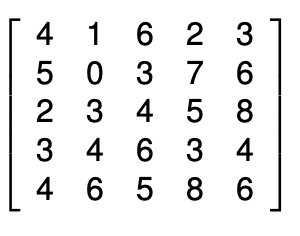
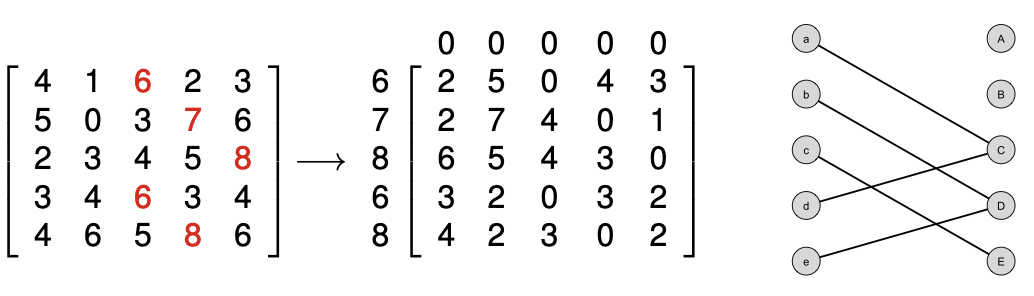
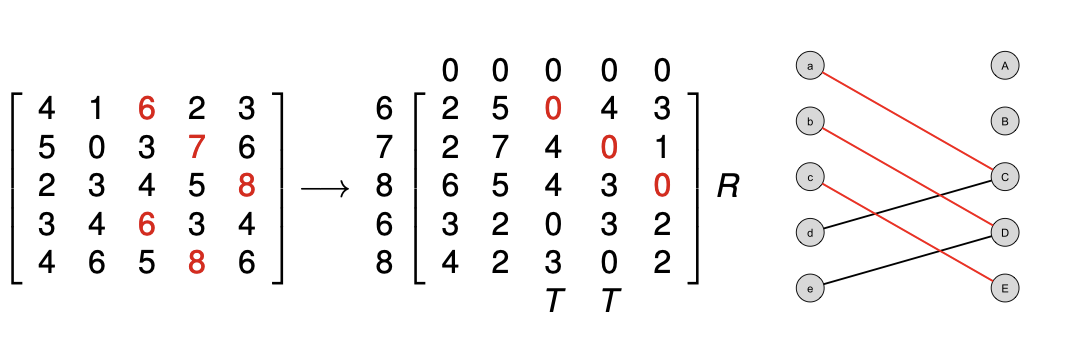
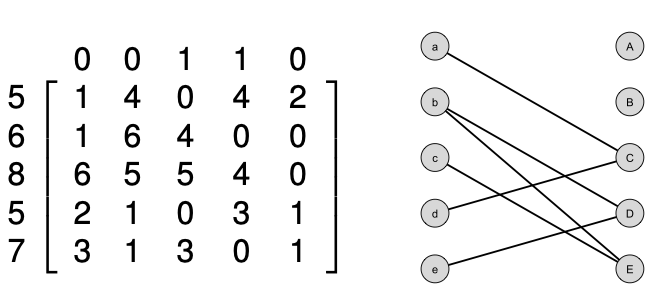

In [40]:
matrix_data = [
    [4, 1, 6, 2, 3],
    [5, 0, 3, 7, 6],
    [2, 3, 4, 5, 8],
    [3, 4, 6, 3, 4],
    [4, 6, 5, 8, 6]
]

wg = WeightedGraph()

# Define partitions using string keys as the algo expects distinct sets
rows = [f"R{i}" for i in range(len(matrix_data))]
cols = [f"C{j}" for j in range(len(matrix_data[0]))]
X = set(rows)
Y = set(cols)

for r_idx, r_node in enumerate(rows):
    for c_idx, c_node in enumerate(cols):
        wg.add_arc((r_node, c_node), matrix_data[r_idx][c_idx])

matching, u_final, v_final = wg.hungarian_algorithm(X, Y)

print("\nMaximum Weight Matching Results:")
total_weight = 0

# Sort for cleaner output
for r in sorted(list(X)):
    if r in matching:
        c = matching[r]
        w = wg.weights[(r, c)]
        total_weight += w
        print(f"  {r} -> {c} (Weight: {w})")

print(f"Total Maximum Weight: {total_weight}")


Maximum Weight Matching Results:
  R0 -> C0 (Weight: 4)
  R1 -> C3 (Weight: 7)
  R2 -> C4 (Weight: 8)
  R3 -> C2 (Weight: 6)
  R4 -> C1 (Weight: 6)
Total Maximum Weight: 31


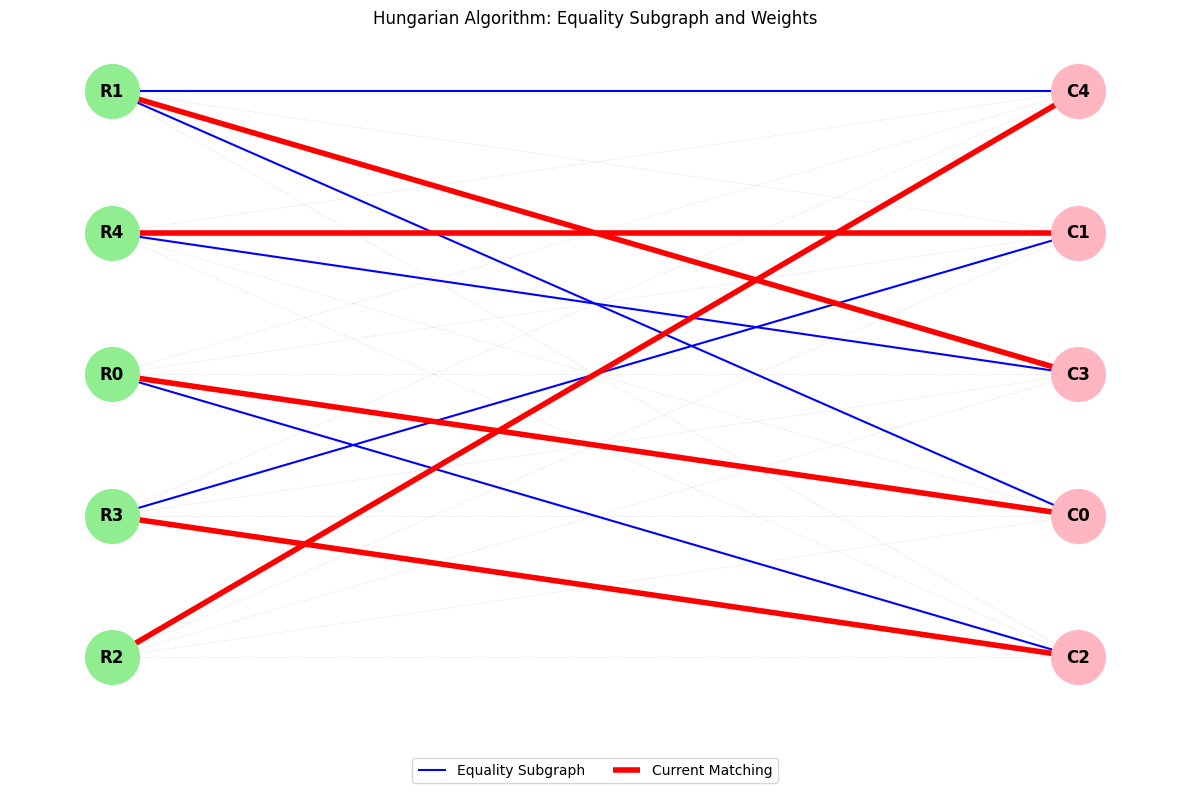

In [41]:
wg.plot_hungarian(X, Y, matching, u_final, v_final)